### Project Title : - Using Lung ultrasound images for building a reliable Point-of-care Covid-19 testing system

#### Binary Classifier : For classifying lung ultrasound images into one of the two categories : Covid and Non Covid

In [1]:
#Mounting the google drive as the data is available there

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


#### Splitting the dataset into training, testing and validation

##### Training dataset will be used for training the model, validation data will be used for adjusting the hyperparameters. The test dataset will be the unseen set of images, that'd be used for testing model's performance on the unseen dataset. 70% of the entire dataset is used as training, 10% as validation and the rest as testing.

In [ ]:
pip install split-folders

In [ ]:
#splitfolders makes it easier for splitting data in form of folders

import splitfolders

#Splitting the entire dataset into training, testing and validation folders

splitfolders.ratio('/content/drive/MyDrive/My_Dataset',output ='binary_two', ratio = (.7,0.1,0.2))

#### Dataset Verification

##### The following piece of code checks the number of images in each class for all the three types of dataset.

In [ ]:
import os
print("Training dataset")
files = os.listdir("/content/drive/MyDrive/binary_two/train/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/binary_two/train/non_covid")
file_count = len(files)
print("Class Non Covid: ",file_count)



print("---------------------")
print("Testing dataset")
files = os.listdir("/content/drive/MyDrive/binary_two/test/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/binary_two/test/non_covid")
file_count = len(files)
print("Class Non Covid: ",file_count)


print("---------------------")
print("Validation dataset")
files = os.listdir("/content/drive/MyDrive/binary_two/val/covid")
file_count = len(files)
print("Class Covid : ",file_count)

files = os.listdir("/content/drive/MyDrive/binary_two/val/non_covid")
file_count = len(files)
print("Class Non Covid: ",file_count)



Training dataset
Class Covid :  2831
Class Non Covid:  6860
---------------------
Testing dataset
Class Covid :  810
Class Non Covid:  1961
---------------------
Validation dataset
Class Covid :  404
Class Non Covid:  980


#### Dataset Loading and Pre-processing

##### It is important to pre-process the images before they are fed into the model. The image pre-processing has been done using Image Data Generator, as the dataset is huge and it'd be feasible to input data in batches. the batch size chosen is 512. The images are rescaled, so that the pixel values lie between 0-1 for all the images. The images have been resized to 197 X 198 pixels.

In [ ]:
#Importing the necessary libraries

import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Creating path for dataset folders
p = Path().cwd()
q = p/'binary_two'

#Images would be fed into the model as a batch of this size
batch_size = 512

#Rescaling the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


#Creating data generators for all the three datasets
train_generator = train_datagen.flow_from_directory(q/'train',target_size=(197,198), batch_size= batch_size,class_mode ='categorical',shuffle = False)

test_generator = test_datagen.flow_from_directory(q/'test',target_size= (197,198), batch_size= batch_size,class_mode ='categorical',shuffle = False)

val_generator = val_datagen.flow_from_directory(q/'val',target_size=(197,198), batch_size= batch_size,class_mode ='categorical',shuffle = False)

        # confirm the iterator works

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 9691 images belonging to 2 classes.
Found 2771 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.
Batch shape=(512, 197, 198, 3), min=0.000, max=1.000


**Creating and Training the baseline model**

##### VGG-16 has been chosen as the baseline model. Given the large amount of data, it's easier to use a pre-trained network for the classification. 

In [ ]:
# include_top = 'False' as we only want the feature extractor part and not the classifier part. The input shape has been given as per our image dataset.

pretrained= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(197,198,3), weights='imagenet')

#We want the model to retain the parameters (weights and biases) it has learned from the image dataset, hence we are freezing the feature extractor layers.
pretrained.trainable=False


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#Functional API has been used for adding classifier layers to the pre-trained part.

inputs = tf.keras.Input(shape=(197,198,3))
x = pretrained(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.Dense(512)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

multi_vgg16 = tf.keras.Model(inputs, outputs)

multi_vgg16.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 197, 198, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 1024)              18875392  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 34,115,906
Trainable params: 19,401,218
Non-tra

In [ ]:
#The above model has been compiled before using it.

multi_vgg16.compile(loss="categorical_crossentropy",optimizer= 'rmsprop' , metrics=["accuracy"])

In [ ]:
#The model has been fit to the train data

baseline_model = multi_vgg16.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 5 , validation_data= val_generator,
             validation_steps = len(val_generator))

Epoch 1/5
19/19 [==============================] - 4965s 258s/step - loss: 123.7740 - accuracy: 0.5699 - val_loss: 4.8110 - val_accuracy: 0.5101
Epoch 2/5
19/19 [==============================] - 80s 4s/step - loss: 14.5476 - accuracy: 0.5193 - val_loss: 7.1834 - val_accuracy: 0.3309
Epoch 3/5
19/19 [==============================] - 80s 4s/step - loss: 3.4794 - accuracy: 0.8221 - val_loss: 0.5935 - val_accuracy: 0.8150
Epoch 4/5
19/19 [==============================] - 80s 4s/step - loss: 32.2937 - accuracy: 0.6502 - val_loss: 1.4682 - val_accuracy: 0.8822
Epoch 5/5
19/19 [==============================] - 80s 4s/step - loss: 0.9334 - accuracy: 0.8969 - val_loss: 0.2555 - val_accuracy: 0.9342


#### Checking model's classification performance on the test data

##### The model's actual performance that matters, is the one it gives on the unseen dataset. The following code gets prediction class for each image in the test dataset and compare them with the true class of the image for getting a true picture of model's performance.

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

#Making predictions on the test data

predict = multi_vgg16.predict(
    test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1,
    use_multiprocessing=False, verbose=0
)

#Getting actual prediction class from the predictions made

vgg_pred_classes_ft = np.argmax(predict, axis=1)

#The true classes
true_classes = test_generator.classes

#Calculating performance metrics

print("Precision score is ", average_precision_score(true_classes, vgg_pred_classes_ft))
print("Accuracy score is ", accuracy_score(true_classes, vgg_pred_classes_ft))
print("Recall is ",recall_score(true_classes, vgg_pred_classes_ft))
print("F1 score is ",f1_score(true_classes, vgg_pred_classes_ft))

Precision score is  0.6673778889168532
Accuracy score is  0.5520491803278689
Recall is  0.6719512195121952
F1 score is  0.6684865028814073


##### Confusion matrix - The confusion matrix makes it easier to look at the predictions made by the model. The following code plots the same for the test dataset.

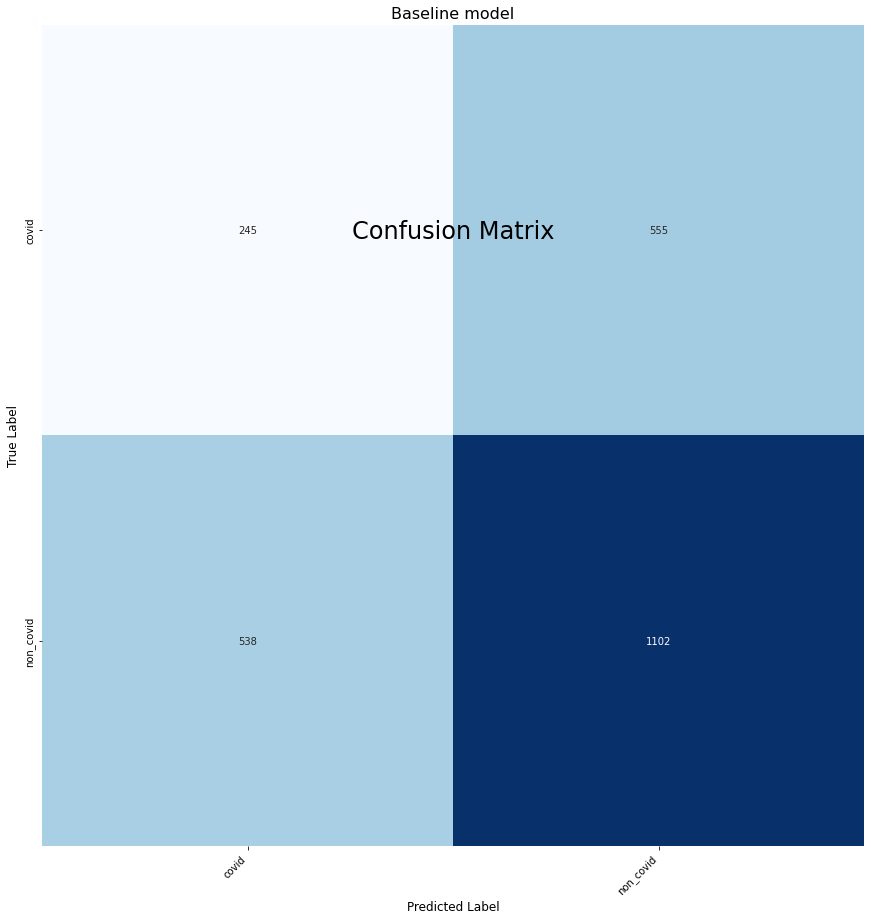

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

true_classes = test_generator.classes

class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax1, title="Baseline model")    

fig.suptitle("Confusion Matrix", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

##### Evidently, the model is better at identifying lung ultrasound images of non covid patients than the covid positive patients. A part of the reason can be, the covid images are limited and the model is getting to learn more from the other category.We'd now try various techniques to deal with the same and performance will be compared to this baseline. 

**Offline Data Augmentation on COVID class**

##### The lung ultrasound images of COVID positive cases in training dataset are roughly around 2700, whereas those for COVID negative are around 8000. That is a massive class imbalance. The following chunk of code creates more images in COVID class from the existing images by transforming them.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import numpy as np
import os
from PIL import Image
import pathlib
from pathlib import Path

# This transformation will be performed on training images at random, this includes rotating the images by 40 degrees, flipping them horizontally.

#Changing the brightness level and zooming in

datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

p = Path().cwd()
image_directory =  p/'binary_split/train/covid'


dataset = []
my_images = os.listdir(image_directory)

for i, image_name in enumerate(my_images): 

    if (image_name.split('.')[1] == 'jpg'): 
        path = os.path.join(image_directory,image_name)       
        image = io.imread(path)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((224,224)) 
        dataset.append(np.array(image))

# A new folder has been created for saving these newly created images       
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=16,
                          save_to_dir= "/content/drive/MyDrive/augmented",
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 300:        
        break

In [ ]:
# This offline augmentation has created around 5000 images of covid class

files = os.listdir("/content/drive/MyDrive/augmented")
file_count = len(files)
print(file_count)

4812


In [ ]:
#The same have been moved to the training dataset

path = "/content/drive/MyDrive/augmented"
d_path = "/content/drive/MyDrive/binary_split/train/covid"

for file in os.listdir(path):
        s = os.path.join(path,file)
        new_path = shutil.move(s,d_path)

In [ ]:
#The training dataset now has 7608 lung ultrasound images of class - COVID

files = os.listdir("/content/drive/MyDrive/binary_split/train/covid")
file_count = len(files)
print(file_count)

7608


#### Dataset Loading and Pre-processing

##### Since we are inputting data using image data generator and pre-processing the images while feeding them to the model. This step has to be repeated again for the next model.

In [ ]:
#Importing the necessary libraries

import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


  #Creating path for dataset folders
p = Path().cwd()
q = p/'binary_split'

  #Images would be fed into the model as a batch of this size
batch_size = 512

        #Rescaling the pixel values
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


        #Creating data generators for all the three datasets
train_generator = train_datagen.flow_from_directory(q/'train',target_size=(224,224), batch_size= batch_size,class_mode ='categorical')

test_generator = test_datagen.flow_from_directory(q/'test',target_size= (224,224), batch_size= batch_size,class_mode ='categorical', shuffle = False)

val_generator = val_datagen.flow_from_directory(q/'val',target_size=(224,224), batch_size= batch_size,class_mode ='categorical')

        # confirm the iterator works

batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))


Found 15870 images belonging to 2 classes.
Found 2440 images belonging to 2 classes.
Found 1579 images belonging to 2 classes.
Batch shape=(512, 224, 224, 3), min=0.000, max=1.000


#### VGG-19

In [ ]:
pretrained= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(224,224,3), weights='imagenet')

pretrained.trainable=False


80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = pretrained(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.Dense(512)(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

vgg19 = tf.keras.Model(inputs, outputs)

#Getting the model architecture
vgg19.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 46,241,346
Trainable params: 26,216,962
Non-tra

In [ ]:
#Compiling the model

vgg19.compile(loss="categorical_crossentropy",optimizer = 'rmsprop', metrics=["accuracy"])

#We wish to monitor the validation loss and save the best model

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras",
                                            save_best_only=True,
                                            monitor="val_loss")


In [ ]:
#Training the model

network_1 = vgg19.fit( train_generator,steps_per_epoch = len(train_generator),epochs= 5 , validation_data= val_generator,
             validation_steps = len(val_generator), callbacks=[callbacks])

Epoch 1/5
31/31 [==============================] - 5835s 188s/step - loss: 42.8404 - accuracy: 0.7369 - val_loss: 0.2109 - val_accuracy: 0.9272
Epoch 2/5
31/31 [==============================] - 107s 3s/step - loss: 17.4931 - accuracy: 0.8537 - val_loss: 0.3577 - val_accuracy: 0.9411
Epoch 3/5
31/31 [==============================] - 109s 3s/step - loss: 0.5628 - accuracy: 0.9425 - val_loss: 0.0125 - val_accuracy: 0.9975
Epoch 4/5
31/31 [==============================] - 106s 3s/step - loss: 11.0937 - accuracy: 0.8342 - val_loss: 0.0231 - val_accuracy: 0.9905
Epoch 5/5
31/31 [==============================] - 106s 3s/step - loss: 0.0410 - accuracy: 0.9894 - val_loss: 6.1886 - val_accuracy: 0.8309


#### Model's performance on test dataset

In [ ]:
import numpy as np


#Loading the best model saved
test_model = tf.keras.models.load_model("fine_tuning.keras")

#Using the same for making predictions
predict = test_model.predict_generator(
    test_generator, workers=0, verbose=0
)

predictedClass = np.argmax(predict, axis=1)

#The actual classes
trueClass = test_generator.classes[test_generator.index_array]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

#Confusion matrix for the predictions made

confusionMatrix = (confusion_matrix(
        y_true = trueClass,                                       
        y_pred = predictedClass))                                

print(confusionMatrix)

[[ 294  506]
 [  19 1621]]


In [ ]:
#The performance scores of the model

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

print("Precision score is ", precision_score(trueClass, predictedClass))
print("Accuracy score is ", accuracy_score(trueClass, predictedClass))
print("Recall is ",recall_score(trueClass, predictedClass))
print("F1 score is ",f1_score(trueClass, predictedClass))

Precision score is  0.7621062529384109
Accuracy score is  0.7848360655737705
Recall is  0.9884146341463415
F1 score is  0.8606318024953544


#### The prediction accuracy improved to 78.4% with data augmentation on COVID class.